In [1]:
using SeisNoise, PyPlot, CUDA, Glob, HDF5, Combinatorics, Random, Statistics, ImageFiltering, FFTW, JLD2, Dates
import SeisNoise: NoiseData
import SeisIO: read_nodal, NodalData, InstrumentPosition, InstrumentResponse, show_str, show_t, show_x, show_os
import FFTW: rfft, irfft
import DSP: hilbert
import Images: findlocalmaxima
import Base:show, size, summary
import PyCall
import FiniteDifferences
anim = PyCall.pyimport("matplotlib.animation")
include("Types.jl")
include("Nodal.jl")
include("Misc.jl")

compute_rms (generic function with 3 methods)

In [2]:
"

Set postprocessing parameters

"

# list all the Greenland files
path = "/1-fnp/petasaur/p-wd03/greenland/Store Glacier DAS data/"
files_1khz = glob("1kHz/*",path)
N = read_nodal("segy", files_1khz[2])

# processing parameters
freqmin, freqmax = 20,50
sgn = "both"
cmin,cmax = 750,4250
maxlag = 1

# choose channels
chan_start = 331
chan_end = 2391
chans = [chan_start,chan_end]

# choose virtual source locations
source_chan = 331

331

In [ ]:
"

Stack all the correlations

"

# list all correlation files
#path = string("/1-fnp/pnwstore1/p-wd05/greenland/correlations/fk_",cmin,"_",cmax,"/all/fk_",sgn,"/")
path = string("/fd1/solinger/correlations/fk_",cmin,"_",cmax,"/")
files = glob("*",path)
files = files[BitVector(1 .- contains.(files,"error"))]

# subset further in time
files = files[56:end] 

# read results and stack
C = load(files[1])["NodalCorrData"]
for f in files[2:end]
    C.corr = C.corr + JLD2.load(f)["NodalCorrData"].corr
end

# save stack
fname = string("/fd1/solinger/correlations/fk_",cmin,"_",cmax,"/2019-07-08_stack.jld2")
JLD2.save(fname,Dict("NodalCorrData"=>C))

In [3]:
"

Filter and carry out cross cable stacking

"

# read stack
fname = string("/fd1/solinger/correlations/fk_",cmin,"_",cmax,"/2019-07-08_stack.jld2")
#fname = string("/fd1/solinger/correlations/fk_",cmin,"_",cmax,"/high_res_correlations_2019-07-08T10:52:22.jld2")
C = JLD2.load(fname)["NodalCorrData"]

# postprocessing
C_filt = deepcopy(C)
clean_up!(C_filt,freqmin,freqmax)

# stack across cable
corr_stack = cross_cable_stack(C_filt,collect(chans[1]:chans[2]))
C_cross_stack = deepcopy(C_filt)
C_cross_stack.corr = corr_stack

# normalize post-stack
abs_max!(C_cross_stack)
abs_max!(C_filt)

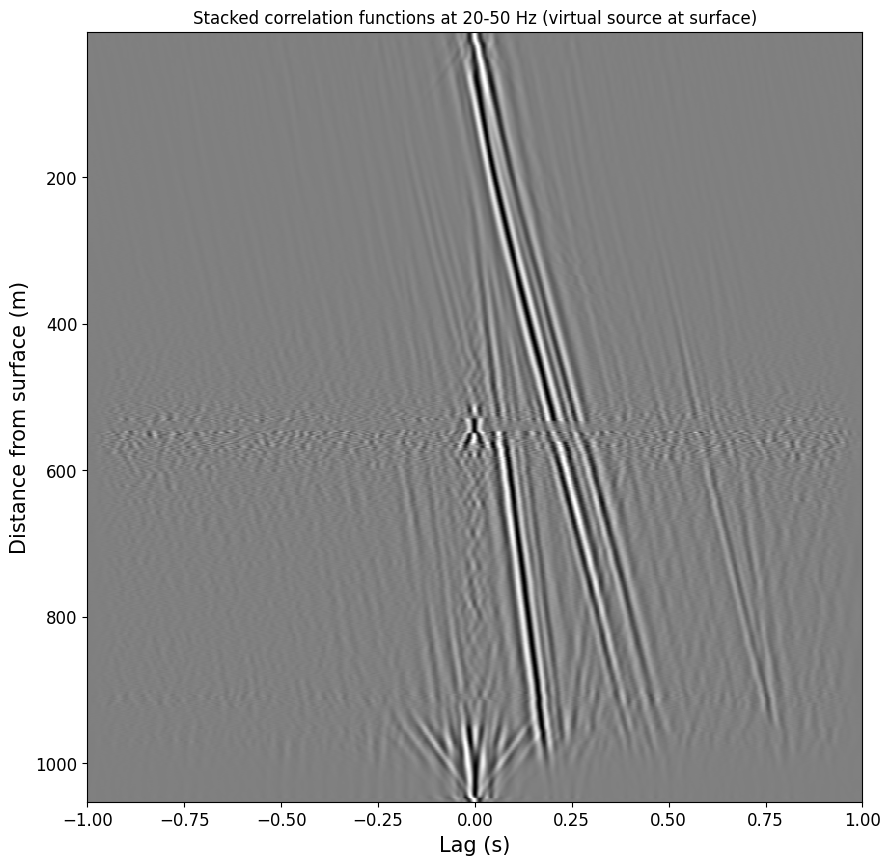

In [5]:
"

Plot stack for surface source

"

# plot results
n = chans[end] - (chans[1])
midpoint = (chans[1]) + Int64(n/2)
plot_chans = [chans[1],midpoint]
title = string("Stacked correlation functions at ",freqmin,"-",freqmax," Hz (virtual source at surface)")
fname = string("/fd1/solinger/correlation_figures/fk_",sgn,"_",cmin,"_",cmax,"_2019-07-08_stack_cross_",freqmin,"-",freqmax,
               "Hz_source_",source_chan,".png")
plot_correlations(C_cross_stack,"common shot",maxlag,plot_chans,source_chan,330,title,fname,75,"gray")

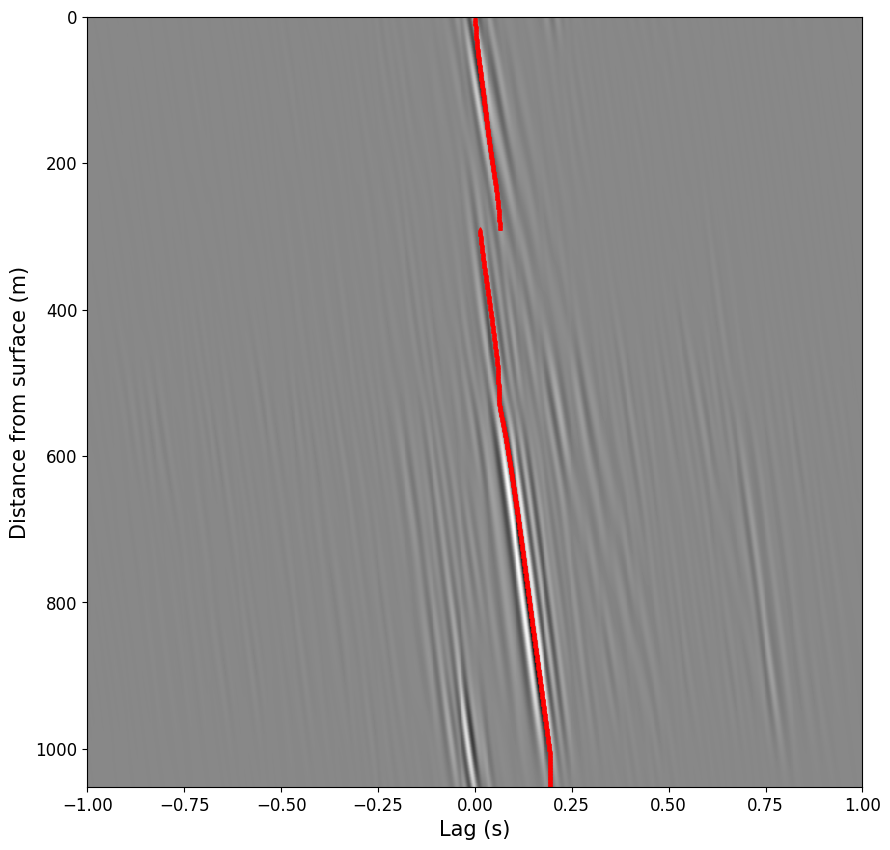

PyObject <matplotlib.collections.PathCollection object at 0x7fc08abda2e8>

In [197]:
"

Measure P-wave velocity with depth

"

# get indices of correct correlations
indices = [j for j in combinations(collect(chans[1]:midpoint),2)]
indices = reduce(vcat,transpose.(indices))
ssp_ind = vec(indices[:,1] .== source_chan .|| indices[:,2] .== source_chan)

# get spacing
spacing = (C.misc[4]["shot_point"]-C.misc[3]["shot_point"])/1000

# load correlation into dummy NodalData
NC = NodalData()
NC.data = C_cross_stack.corr[:,ssp_ind]
NC.misc = C_cross_stack.misc
NC.fs = C_cross_stack.fs
NC.n = sum(ssp_ind)

# fk filter to remove other phases
NC_fft = rfft(NC,[1,2])
fk!(NC_fft,3800,4250,"neg")
NC_fk = irfft(NC_fft,[1,2])
C_fk = deepcopy(C_cross_stack)
C_fk.corr = NC_fk.data

# compute envelope value of each correlation function
envs = abs.(hilbert(C_fk.corr))

# zero out some regions
envs[480:end,:] .= 0
envs[1:440,800:end] .= 0

# get max value of massaged envelope functions
peaks = argmax(abs.(envs),dims=1)

# linearly interpolate to correct for temporal aliasing
peak_ind = convert(Array{Float64}, getindex.(peaks, 1))
counter = 0
for p in range(1,size(peak_ind,2)-1)
    if peak_ind[p+1] == peak_ind[p]
        counter = counter + 1
    elseif counter != 0
        increment = 1/(counter+1)
        peak_ind[p-counter+1:p] = peak_ind[p-counter+1:p] + range(1,counter).*increment
        counter = 0
    end
end

# get time and position of arrivals
arrival_times = (peak_ind.-div(size(envs,1),2))./C_fk.fs[1]
pos = getindex.(peaks,2)*spacing

# migrate the arrival times associated with source at 200m
# currently, the discontinuity is manually identified
disc = 284
migr_arrivals = deepcopy(arrival_times)
migr_arrivals[disc:end] = migr_arrivals[disc:end].+migr_arrivals[disc-1].-migr_arrivals[disc]

# get phase velocity
phase_velocity = pos ./ migr_arrivals

# get phase velocity assuming some offset
offset = 200
theta = atan.(pos./offset)
offset_velocity = sin.(theta) .* pos ./ migr_arrivals

# use unique arrival times to estimate velocity down the cable 
unique_ind = unique(i -> migr_arrivals[i], 1:length(migr_arrivals))
unique_arrivals = unique(migr_arrivals)
unique_pos = pos[unique_ind]
phase_velocity2 = diff(unique_pos,dims=1) ./ diff(unique_arrivals,dims=1)
theta2 = atan.(unique_pos./offset)[2:end]
offset_velocity2 = sin.(theta2) .* diff(unique_pos,dims=1) ./ diff(unique_arrivals,dims=1)

# make a plot of the correlations and phase velocity
profile_start = (indices[ssp_ind,1][1] - chans[1]) * spacing
profile_end = (indices[ssp_ind,2][end] - chans[1]) * spacing
figure(figsize=(10,10))
extent=[-maxlag,maxlag,profile_end,profile_start]
imshow(C_fk.corr', cmap="gray", interpolation=:none, aspect="auto",extent=extent)
ylabel("Distance from surface (m)",fontsize=15)
xlabel("Lag (s)",fontsize=15)
xticks(fontsize=12)
yticks(fontsize=12)
plt.scatter(arrival_times,pos,c="red",marker="^",s=5)

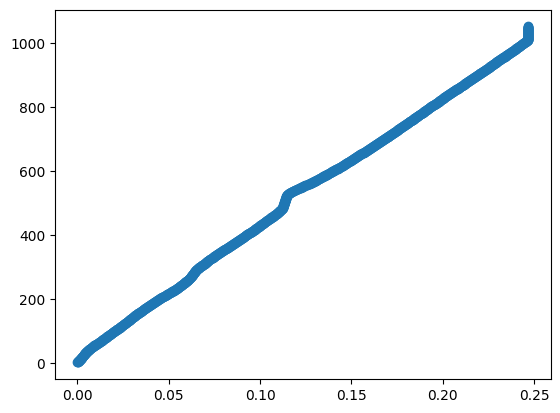

PyObject <matplotlib.collections.PathCollection object at 0x7fc08aaf25c0>

In [198]:
disc = 284
migr_arrivals = deepcopy(arrival_times)
migr_arrivals[disc:end] = migr_arrivals[disc:end].+migr_arrivals[disc-1].-migr_arrivals[disc]
plt.scatter(migr_arrivals,pos)

Mean velocity (cumulative): 4465.837288624733
Mean velocity (diff): 3986.838664900664

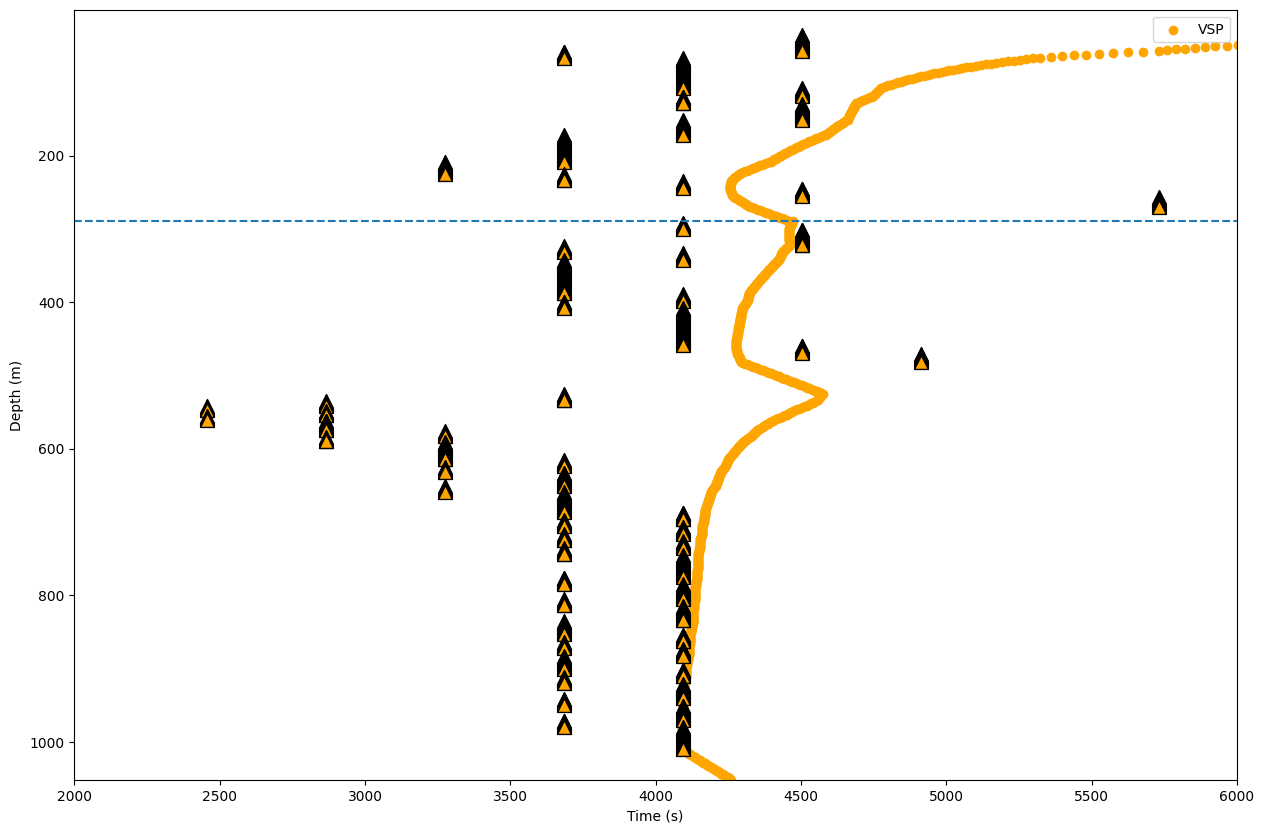

In [199]:
"

Plot P-wave velocity as a function of depth

"

fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(phase_velocity[isfinite.(phase_velocity)],pos[isfinite.(phase_velocity)],c="orange",label="VSP")
ax.hlines(xmax = 6000,xmin=2000,disc*spacing,linestyle="--")
ax.scatter(phase_velocity2,unique_pos[2:end],c="orange",marker="^",edgecolor="k",s=100)
#ax.scatter(offset_velocity[isfinite.(offset_velocity)],pos[isfinite.(offset_velocity)],c="r",label="Offset VSP")
#ax.scatter(offset_velocity2,unique_pos[2:end],c="r",marker="^",edgecolor="k",s=100)
ax.set_ylim(pos[1],pos[end])
ax.invert_yaxis()
ax.set_ylabel("Depth (m)")
ax.set_xlabel("Time (s)")
plt.legend()
ax.set_xlim(2000,6000)
plt.show()

println("Mean velocity (cumulative): ",mean(phase_velocity[isfinite.(phase_velocity)]))
#println("Mean velocity (diff) from unique values: ",mean(phase_velocity2))
print("Mean velocity (diff): ",mean(phase_velocity2[phase_velocity2 .> 3500 .&& phase_velocity2 .< 4600]))

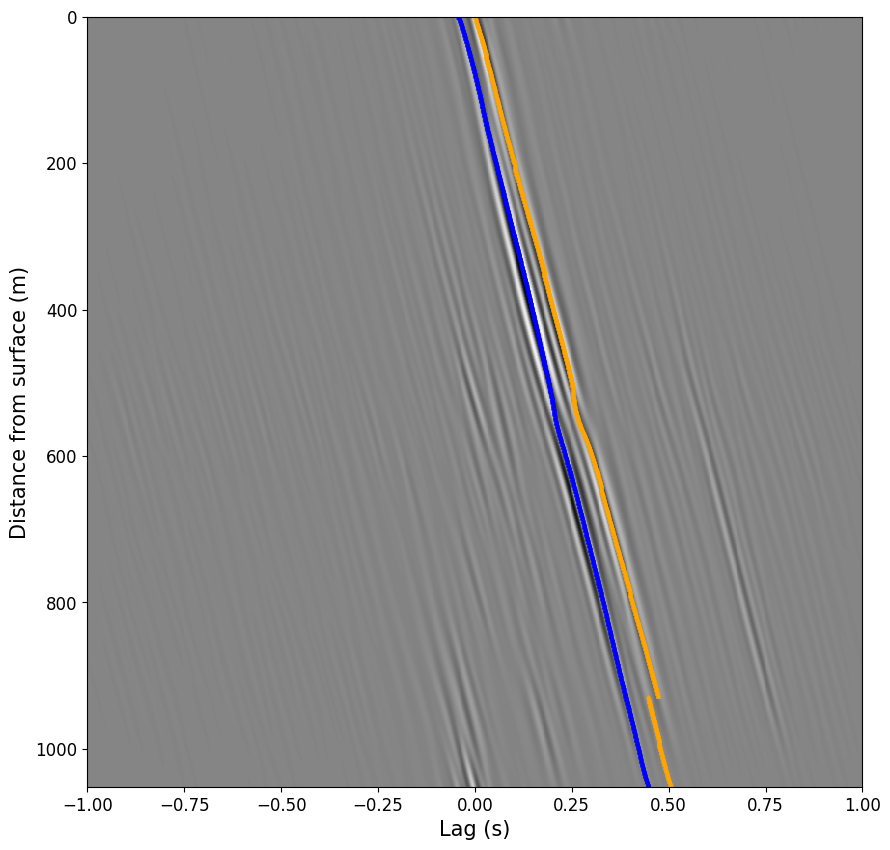

PyObject <matplotlib.collections.PathCollection object at 0x7fc0799c43c8>

In [200]:
"

Measure S-wave velocity with depth

"

# get indices of correct correlations
indices = [j for j in combinations(collect(chans[1]:midpoint),2)]
indices = reduce(vcat,transpose.(indices))
ssp_ind = vec(indices[:,1] .== source_chan .|| indices[:,2] .== source_chan)

# load correlation into dummy NodalData
NC = NodalData()
NC.data = C_cross_stack.corr[:,ssp_ind]
NC.misc = C_cross_stack.misc
NC.fs = C_cross_stack.fs
NC.n = sum(ssp_ind)

# fk filter to remove other phases
NC_fft = rfft(NC,[1,2])
fk!(NC_fft,1750,2250,"neg")
NC_fk = irfft(NC_fft,[1,2])
C_fk = deepcopy(C_cross_stack)
C_fk.corr = NC_fk.data

# compute envelope value of each correlation function
envs = abs.(hilbert(C_fk.corr))

# zero out some regions
envs[1:460,400:end] .= 0
envs[1:520,900:end] .= 0

# get first and second max values of massaged envelope functions
peaks = argmax(abs.(envs),dims=1)

# get indices of two largest envelope maxima
first_peaks = zeros(0)
second_peaks = zeros(0)
for i in range(1,size(envs,2))
    
    # get all maxima
    peak_inds = findlocalmaxima(envs[:,i])
    peak_inds = (getindex.(peak_inds, 1))
    
    # save index of largest peak
    max_ind = argmax(envs[:,i][peak_inds])
    append!(first_peaks,peak_inds[max_ind])
    
    # remove that element
    peak_inds = deleteat!(peak_inds, max_ind)
    
    # save index of second largest peak
    max_ind = argmax(envs[:,i][peak_inds])
    append!(second_peaks,peak_inds[max_ind])
end

# find first maxima and second maxima
both_peaks = hcat(first_peaks,second_peaks)
second_ind = argmax(both_peaks,dims=2)
second_peaks = both_peaks[second_ind]
first_ind = argmin(both_peaks,dims=2)
first_peaks = both_peaks[first_ind]

# linearly interpolate to correct for temporal aliasing
counter = 0
for p in range(1,size(first_peaks,1)-1)
    if first_peaks[p+1] == first_peaks[p]
        counter = counter + 1
    elseif counter != 0
        increment = 1/(counter+1)
        first_peaks[p-counter+1:p] = first_peaks[p-counter+1:p] + range(1,counter).*increment
        counter = 0
    end
end

# get time and position of arrivals
first_arrival_times = (first_peaks.-div(size(envs,1),2))./C_fk.fs[1]
first_arrival_times = first_arrival_times'
second_arrival_times = (second_peaks.-div(size(envs,1),2))./C_fk.fs[1]
second_arrival_times = second_arrival_times'
pos = getindex.(peaks,2)*spacing

# get phase velocities
first_phase_velocity = pos ./ (first_arrival_times.-first_arrival_times[1])
second_phase_velocity = pos ./ (second_arrival_times.-second_arrival_times[1])

# get phase velocity assuming some offset
offset = 100
theta = atan.(pos./offset)
offset_velocity = sin.(theta) .* pos ./ (first_arrival_times.-first_arrival_times[1])

# use unique arrival times to estimate velocity down the cable 
unique_ind = unique(i -> first_arrival_times[i], 1:length(first_arrival_times))
unique_arrivals = unique(first_arrival_times)
unique_pos = pos[unique_ind]
phase_velocity2 = diff(unique_pos,dims=1) ./ diff(unique_arrivals,dims=1)
theta2 = atan.(unique_pos./offset)[2:end]
offset_velocity2 = sin.(theta2) .* diff(unique_pos,dims=1) ./ diff(unique_arrivals,dims=1)

# make a plot of the correlations and phase velocity
spacing = (C.misc[4]["shot_point"]-C.misc[3]["shot_point"])/1000
profile_start = (indices[ssp_ind,1][1] - chans[1]) * spacing
profile_end = (indices[ssp_ind,2][end] - chans[1]) * spacing
figure(figsize=(10,10))
extent=[-maxlag,maxlag,profile_end,profile_start]
imshow(C_fk.corr', cmap="gray", interpolation=:none, aspect="auto",extent=extent)
ylabel("Distance from surface (m)",fontsize=15)
xlabel("Lag (s)",fontsize=15)
xticks(fontsize=12)
yticks(fontsize=12)
plt.scatter(first_arrival_times,pos,c="blue",marker="^",s=5)
plt.scatter(second_arrival_times,pos,c="orange",marker="^",s=5)

Mean velocity (cumulative): 2077.76521812396
Mean velocity (diff): 2182.3850194363454

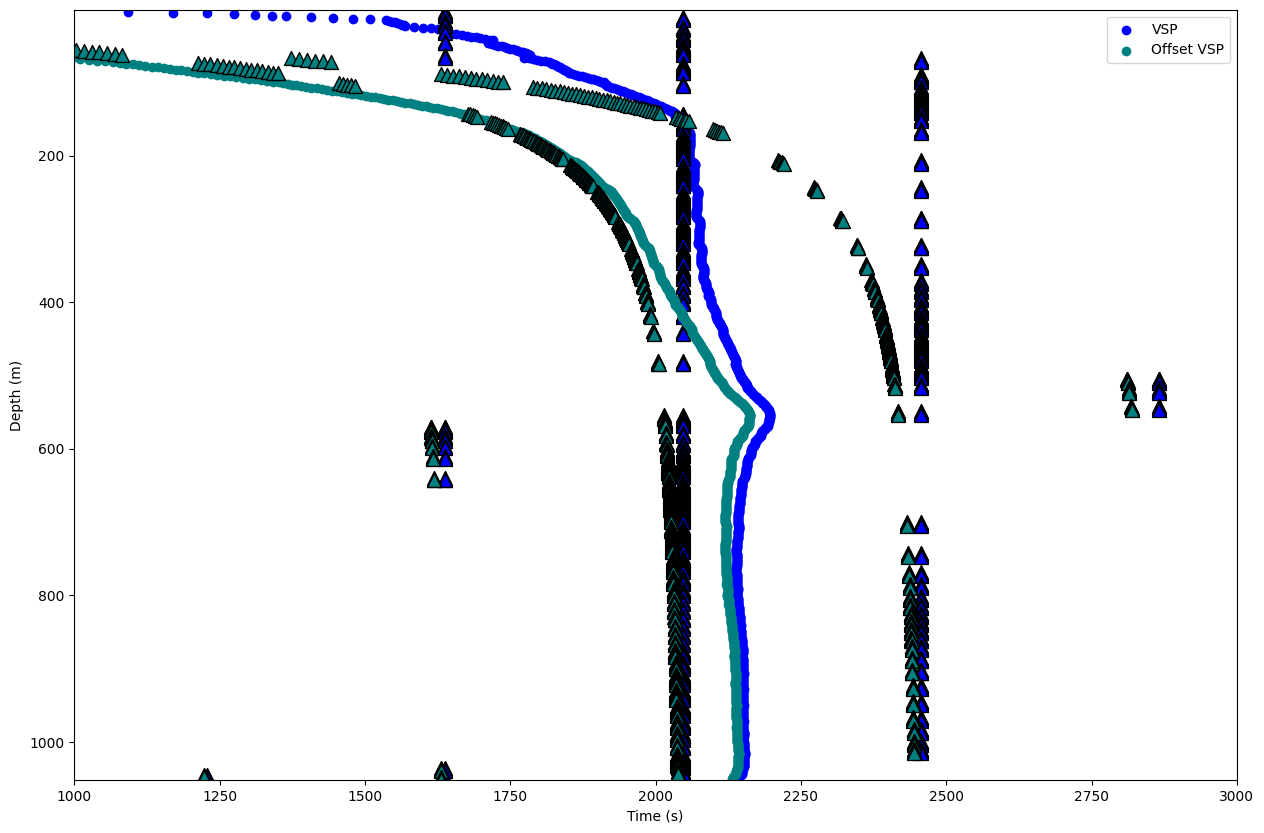

In [204]:
"

Plot S wave velocity (1)

"

fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(first_phase_velocity[isfinite.(first_phase_velocity)],pos[isfinite.(first_phase_velocity)],c="blue",label="VSP")
ax.scatter(phase_velocity2,unique_pos[2:end],c="blue",marker="^",edgecolor="k",s=100)
ax.scatter(offset_velocity[isfinite.(offset_velocity)],pos[isfinite.(offset_velocity)],c="teal",label="Offset VSP")
ax.scatter(offset_velocity2,unique_pos[2:end],c="teal",marker="^",edgecolor="k",s=100)
plt.legend()
ax.set_ylim(pos[1],pos[end])
ax.invert_yaxis()
ax.set_ylabel("Depth (m)")
ax.set_xlabel("Time (s)")
ax.set_xlim(1000,3000)
plt.show()


println("Mean velocity (cumulative): ",mean(first_phase_velocity[isfinite.(first_phase_velocity)]))
#println("Mean velocity (diff) from unique values: ",mean(phase_velocity2))
print("Mean velocity (diff): ",mean(phase_velocity2))

In [ ]:
"

Plot S wave velocity (2)

"

fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(first_phase_velocity,pos,c="orange")
ax.set_ylim(pos[1],pos[end])
ax.invert_yaxis()
ax.set_ylabel("Depth (m)")
ax.set_xlabel("Time (s)")
ax.set_xlim(1000,2500)
plt.show()

In [ ]:
"

Plot stack for each virtual source

"

# plot cross cable stack results for all sources
n = chans[end] - (chans[1])
midpoint = (chans[1]) + Int64(n/2)
plot_chans = [chans[1],midpoint]
for chan_i = plot_chans[1]:plot_chans[2]
    title = string("Stacked correlation functions at ",freqmin,"-",freqmax,
               "Hz (virtual source at channel ",chan_i,")")
    fname = string("/fd1/solinger/correlation_figures/fk_",cmin,"_",cmax,
               "/all_sources/stack_cross_",freqmin,"-",freqmax,"Hz_source_",chan_i,".png")
    plot_correlations(C_cross_stack,"common shot",maxlag,plot_chans,chan_i,331,title,fname,75,"gray")
    PyPlot.close()
end

In [ ]:
"

Postprocess and plot each hourly stack

"

# list all the Greenland files
path = "/1-fnp/petasaur/p-wd03/greenland/Store Glacier DAS data/"
files_1khz = glob("1kHz/*",path)
N = read_nodal("segy", files_1khz[2])

# processing parameters
freqmin, freqmax = 20,50
sgn = "both"
cmin,cmax = 750,4250
maxlag = 1

# choose channels
chan_start = 331
chan_end = 2391
chans = [chan_start,chan_end]

# choose virtual source locations
source_chan = 331

# list all correlation files
path = string("/fd1/solinger/correlations/fk_",cmin,"_",cmax,"/")
#path = string("/1-fnp/pnwstore1/p-wd05/greenland/correlations/fk_",cmin,"_",cmax,"/all/fk_",sgn,"/")
files = glob("*",path)
files = files[BitVector(1 .- contains.(files,"error"))]

# loop through each hourly stack
for f in files
    
    try
        # read stack
        C = JLD2.load(f)["NodalCorrData"]

        # postprocess
        clean_up!(C,freqmin,freqmax)

        # stack across cable
        corr_stack = cross_cable_stack(C,collect(chans[1]:chans[2]))
        C_cross_stack = C
        C_cross_stack.corr = corr_stack

        # normalize post-stack
        abs_max!(C_cross_stack)

        # plot results
        n = chans[2] - (chans[1])
        midpoint = (chans[1]) + Int64(n/2)
        plot_chans = [chans[1],midpoint]
        timestamp = split(split(f,"_")[4],".")[1]
        datetime = Dates.DateTime(timestamp)-Hour(1)
        datestring = string(datetime)
        title = string("Stacked correlation functions at ",freqmin,"-",freqmax," Hz (virtual source at surface) at ",datestring)
        fname = string("/fd1/solinger/correlation_figures/hourly_stacks/fk_",sgn,"_",cmin,"_",cmax,"_1khz_stack_cross_",freqmin,"-",freqmax,
                   "Hz_source_",source_chan,"_T",datestring,".png")
        plot_correlations(C_cross_stack,"common shot",maxlag,plot_chans,source_chan,331,title,fname,75,"gray")

        println("Plotted file "*f)
        flush(stdout)

    catch
        println("Issue with file "*f)
        flush(stdout)
    end
        
end
